## **Baseline model**

In [21]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from bike_demand_forecasting.utils import get_paths

In [22]:
# Retrieve Path
paths = get_paths()
DATA_DIR = paths["DATA_DIR"]

# Read data
df_hourly = pd.read_csv(DATA_DIR / "processed" / "df_started_hourly_full.csv")
df_hourly["started_at"] = pd.to_datetime(df_hourly["started_at"])

In [23]:
# Same warm-up as in notebook 03 (lags=24,168 and rolling features with shift(24), max window=168)
warmup_hours = max(168, 24 + 168 - 1)  # = 191
t0 = df_hourly["started_at"].min() + pd.Timedelta(hours=warmup_hours)

# Align baseline data to the same valid time window as the feature-engineered dataset 
# (after lag/rolling warm-up removal)
df_hourly = df_hourly[df_hourly["started_at"] >= t0].copy()

In [24]:
df_hourly.shape

(17353, 9)

In [25]:
df_hourly.head()

,started_at,y,year,month,day,hour,dayofweek,is_weekend,dayofyear
191,2024-01-08 23:00:00,161,2024,1,8,23,0,0,8
192,2024-01-09 00:00:00,47,2024,1,9,0,1,0,9
193,2024-01-09 01:00:00,10,2024,1,9,1,1,0,9
194,2024-01-09 02:00:00,14,2024,1,9,2,1,0,9
195,2024-01-09 03:00:00,6,2024,1,9,3,1,0,9


In [26]:
df_hourly.dtypes

started_at    datetime64[ns]
y                      int64
year                   int64
month                  int64
day                    int64
hour                   int64
dayofweek              int64
is_weekend             int64
dayofyear              int64
dtype: object

In [27]:
# Convert to in16 to increase pipeline speed
print(df_hourly["y"].max())

int_cols = df_hourly.select_dtypes("int64").columns
df_hourly[int_cols] = df_hourly[int_cols].astype("int16")

3180


In [28]:
from bike_demand_forecasting.utils import split_dev_test, separate_X_y

In [29]:
# Separate Dataset : dev set (trainval) & test set
df_dev, df_test = split_dev_test(df_hourly, test_pct = 0.2)

In [30]:
# Separate features and target 
X_dev, y_dev = separate_X_y(df_dev)
X_test, y_test = separate_X_y(df_test)

In [31]:
# Time-based cross-validation on the development set
tscv = TimeSeriesSplit(
    n_splits=5,
    test_size=24*30,  # 30 validation days
    gap=24*7,          # 7-day purge gap
)

In [32]:
# Basic integrity checks for train/test splits
assert len(X_dev) == len(y_dev)
assert len(X_test) == len(y_test)

# Temporal split check: development data must be strictly earlier than test data
assert X_dev["started_at"].max() < X_test["started_at"].min()

# No timestamp overlap between development and test sets
assert set(X_dev["started_at"]).isdisjoint(set(X_test["started_at"]))


In [33]:
# Grid search parmaeteres
param_grid = {
    "reg__n_estimators": [200, 400],
    "reg__max_depth": [8, None],
    "reg__min_samples_leaf": [1, 3],
}

In [34]:
# Pipeline
bool_cols = ["is_weekend"]
num_cols = ["year", "hour", "dayofweek", "month", "dayofyear"]

preprocess = ColumnTransformer(
    transformers=[
        ("bin", OneHotEncoder(drop="if_binary", handle_unknown="ignore"), bool_cols),
        ("num", "passthrough", num_cols),
    ],
    remainder="drop"
)

model = Pipeline([
    ("prep", preprocess),
    ("reg", RandomForestRegressor(random_state=42))
])

In [35]:
from sklearn.metrics import make_scorer
from bike_demand_forecasting.metrics import smape, bias

scoring = {
    "mae": "neg_mean_absolute_error",
    "mape": "neg_mean_absolute_percentage_error",
    "smape": make_scorer(smape, greater_is_better=False),
    "bias": make_scorer(bias, greater_is_better=False)
}

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=tscv,
    scoring=scoring,
    refit="mae",
    n_jobs=-1,
    verbose=1
)

grid.fit(X_dev, y_dev)

# Final hold-out evaluation
best_model = grid.best_estimator_

best_model

Fitting 5 folds for each of 8 candidates, totalling 40 fits


,steps,"[('prep', ...), ('reg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('bin', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


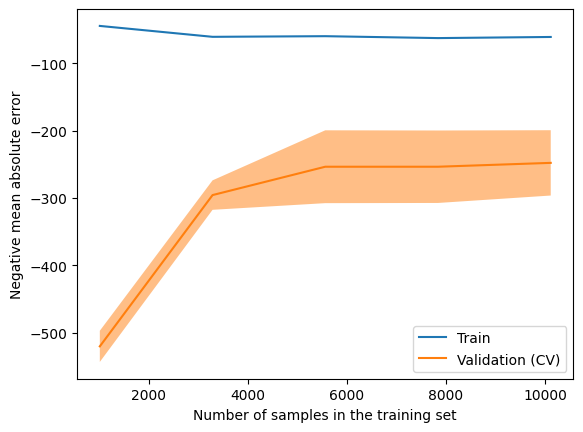

In [36]:
from sklearn.model_selection import LearningCurveDisplay
import matplotlib.pyplot as plt

disp = LearningCurveDisplay.from_estimator(
    grid.best_estimator_,
    X_dev, y_dev,
    cv=tscv,
    scoring="neg_mean_absolute_error"
)

# Rename legend labels
disp.ax_.lines[0].set_label("Train")
disp.ax_.lines[1].set_label("Validation (CV)")
disp.ax_.legend()
plt.show()

In [37]:
import joblib

WORK_DIR = paths["WORK_DIR"]

model_dir = WORK_DIR / "models"
model_dir.mkdir(parents = True, exist_ok = True)

# Save models (baseline, baseline grid)
joblib.dump(best_model, model_dir / "rfg_baseline.joblib")
joblib.dump(grid, model_dir / "rfg_baseline_grid.joblib")

['/mnt/c/Users/33760/Desktop/bike-demand-forecasting/models/rfg_baseline_grid.joblib']

In [38]:
DATA_PROCESSED_DIR = DATA_DIR / "processed"

# Create Folder
DATA_PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Save the test set & label to data/processed
X_test.to_csv(DATA_PROCESSED_DIR / "X_test_baseline.csv", index=False)
y_test.to_frame(name="y").to_csv(DATA_PROCESSED_DIR / "y_test_baseline_fe.csv", index=False)